# Phase B: Modèles de Prédiction Complets

In [4]:
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import warnings
warnings.filterwarnings('ignore')

# Create models directory
os.makedirs('../models', exist_ok=True)

# Load prepared data
df = pd.read_parquet("../Data/prepared_reviews.parquet")
print(f"Dataset shape: {df.shape}")
df.head(1)

Dataset shape: (1000000, 4)


,text,stars,polarity,text_length
0,Went for lunch and found that my burger was me...,2,negative,394


In [6]:
# Sample for training
SAMPLE_SIZE = 30000
df_sample = df.sample(min(SAMPLE_SIZE, len(df)), random_state=42)

print(f"Using {len(df_sample)} samples")

# Polarity mapping
polarity_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df_sample['polarity_num'] = df_sample['polarity'].map(polarity_map)

# Split
X = df_sample['text']
y = df_sample['polarity_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train: {len(X_train)}, Test: {len(X_test)}")

df_sample.head(1)

Using 30000 samples
Train: 24000, Test: 6000


,text,stars,polarity,text_length,polarity_num
987231,I'm not quite sure what the hype is all about ...,1,negative,238,0


## 1. Représentation: N-Grammes (CountVectorizer)

In [7]:
# N-Gram Vectorizer (unigrams + bigrams)
ngram_vectorizer = CountVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')

X_train_ngram = ngram_vectorizer.fit_transform(X_train)
X_test_ngram = ngram_vectorizer.transform(X_test)

print(f"N-Gram shape: {X_train_ngram.shape}")

# Save vectorizer
with open('../models/ngram_vectorizer.pkl', 'wb') as f:
    pickle.dump(ngram_vectorizer, f)

N-Gram shape: (24000, 5000)


## 2. Représentation: TF-IDF

In [8]:
# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF shape: {X_train_tfidf.shape}")

# Save vectorizer
with open('../models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

TF-IDF shape: (24000, 5000)


## 3. Représentation: LLM Embeddings (Sentence Transformers)

In [9]:
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

# Use a smaller, faster model
llm_model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings (batch for speed)
print("Generating LLM embeddings...")

X_train_llm = llm_model.encode(X_train.tolist(), show_progress_bar=True, batch_size=64)
X_test_llm = llm_model.encode(X_test.tolist(), show_progress_bar=True, batch_size=64)

print(f"LLM Embeddings shape: {X_train_llm.shape}")

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 290.19it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Generating LLM embeddings...


Batches: 100%|██████████| 94/94 [01:41<00:00,  1.08s/it]

LLM Embeddings shape: (24000, 384)


---
# ML CLASSIQUE

In [2]:
# Store all results
results = []

def train_and_eval(model, name, X_tr, X_te, y_tr, y_te, representation):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    results.append({'Model': name, 'Representation': representation, 'Accuracy': acc})
    print(f"{name} ({representation}): {acc:.4f}")
    return model, y_pred

### 4.1 ML + N-Gram

In [10]:
print("=== ML + N-Gram ===")
lr_ngram, _ = train_and_eval(LogisticRegression(max_iter=500, n_jobs=-1), 'Logistic Regression', X_train_ngram, X_test_ngram, y_train, y_test, 'N-Gram')
svm_ngram, _ = train_and_eval(LinearSVC(max_iter=1000), 'SVM', X_train_ngram, X_test_ngram, y_train, y_test, 'N-Gram')
nb_ngram, _ = train_and_eval(MultinomialNB(), 'Naive Bayes', X_train_ngram, X_test_ngram, y_train, y_test, 'N-Gram')
rf_ngram, _ = train_and_eval(RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42), 'Random Forest', X_train_ngram, X_test_ngram, y_train, y_test, 'N-Gram')

=== ML + N-Gram ===
Logistic Regression (N-Gram): 0.8353
SVM (N-Gram): 0.8167
Naive Bayes (N-Gram): 0.7932
Random Forest (N-Gram): 0.8307


### 4.2 ML + TF-IDF

In [11]:
print("\n=== ML + TF-IDF ===")
lr_tfidf, _ = train_and_eval(LogisticRegression(max_iter=500, n_jobs=-1), 'Logistic Regression', X_train_tfidf, X_test_tfidf, y_train, y_test, 'TF-IDF')
svm_tfidf, y_pred_best = train_and_eval(LinearSVC(max_iter=1000), 'SVM', X_train_tfidf, X_test_tfidf, y_train, y_test, 'TF-IDF')
nb_tfidf, _ = train_and_eval(MultinomialNB(), 'Naive Bayes', X_train_tfidf, X_test_tfidf, y_train, y_test, 'TF-IDF')
rf_tfidf, _ = train_and_eval(RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42), 'Random Forest', X_train_tfidf, X_test_tfidf, y_train, y_test, 'TF-IDF')


=== ML + TF-IDF ===
Logistic Regression (TF-IDF): 0.8622
SVM (TF-IDF): 0.8560
Naive Bayes (TF-IDF): 0.8245
Random Forest (TF-IDF): 0.8273


### 4.3 ML + LLM Embeddings

In [12]:
print("\n=== ML + LLM Embeddings ===")
lr_llm, _ = train_and_eval(LogisticRegression(max_iter=500, n_jobs=-1), 'Logistic Regression', X_train_llm, X_test_llm, y_train, y_test, 'LLM')
svm_llm, _ = train_and_eval(LinearSVC(max_iter=1000), 'SVM', X_train_llm, X_test_llm, y_train, y_test, 'LLM')
rf_llm, _ = train_and_eval(RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42), 'Random Forest', X_train_llm, X_test_llm, y_train, y_test, 'LLM')


=== ML + LLM Embeddings ===
Logistic Regression (LLM): 0.8447
SVM (LLM): 0.8458
Random Forest (LLM): 0.8030


---
# DEEP LEARNING

In [13]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [14]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_classes=3):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim//2, num_classes)
        )
    def forward(self, x):
        return self.model(x)

class CNN1D(nn.Module):
    def __init__(self, input_dim, num_classes=3):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.3)
    def forward(self, x):
        x = x.unsqueeze(1)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x).squeeze(-1)
        x = self.dropout(x)
        return self.fc(x)

class BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_classes=3):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        self.dropout = nn.Dropout(0.3)
    def forward(self, x):
        x = x.unsqueeze(1)  # (batch, seq=1, features)
        _, (h, _) = self.lstm(x)
        h = torch.cat((h[0], h[1]), dim=1)
        h = self.dropout(h)
        return self.fc(h)

In [15]:
def train_dl_model(model, train_loader, epochs=5, lr=0.001):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"  Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")
    return model

def eval_dl_model(model, test_loader, y_test_vals, representation, name):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for X_batch, _ in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
    acc = accuracy_score(y_test_vals, all_preds)
    results.append({'Model': name, 'Representation': representation, 'Accuracy': acc})
    print(f"{name} ({representation}): {acc:.4f}")
    return all_preds

### 5.1 Deep Learning + TF-IDF

In [17]:
# Prepare TF-IDF tensors
X_train_tensor_tfidf = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
X_test_tensor_tfidf = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

train_ds_tfidf = TensorDataset(X_train_tensor_tfidf, y_train_tensor)
test_ds_tfidf = TensorDataset(X_test_tensor_tfidf, y_test_tensor)
train_loader_tfidf = DataLoader(train_ds_tfidf, batch_size=128, shuffle=True)
test_loader_tfidf = DataLoader(test_ds_tfidf, batch_size=128)

print("=== Deep Learning + TF-IDF ===")
print("Training MLP...")
mlp_tfidf = train_dl_model(MLP(X_train_tfidf.shape[1]), train_loader_tfidf, epochs=5)
eval_dl_model(mlp_tfidf, test_loader_tfidf, y_test.values, 'TF-IDF', 'MLP')

=== Deep Learning + TF-IDF ===
Training MLP...
  Epoch 1/5, Loss: 0.5655
  Epoch 2/5, Loss: 0.3256
  Epoch 3/5, Loss: 0.2530
  Epoch 4/5, Loss: 0.1947
  Epoch 5/5, Loss: 0.1381
MLP (TF-IDF): 0.8353


[np.int64(2),
 np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(2),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(0),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(0),
 np.int64(2),
 np.int64(0),
 np.int64(2),
 np.int64(0),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(0),
 np.int64(0),
 np.int64(2),
 np.int64(2),
 np.int64(0),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(0),
 np.int64(0),
 np.int64(2),
 np.int64(2),
 np.int64(1),
 np.int64(2),
 np.int64(0),
 np.int64(2),
 np.int64(0),
 np.int64(2),
 np.int64(2),
 np.int64(0),
 np.int64(2),
 np.int64(0),
 np.int64(0),
 np.int64(2),
 np.int64(2),
 np.int64(0),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(0),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.in

### 5.2 Deep Learning + N-Gram

In [18]:
# Prepare N-Gram tensors
X_train_tensor_ngram = torch.tensor(X_train_ngram.toarray(), dtype=torch.float32)
X_test_tensor_ngram = torch.tensor(X_test_ngram.toarray(), dtype=torch.float32)

train_ds_ngram = TensorDataset(X_train_tensor_ngram, y_train_tensor)
test_ds_ngram = TensorDataset(X_test_tensor_ngram, y_test_tensor)
train_loader_ngram = DataLoader(train_ds_ngram, batch_size=128, shuffle=True)
test_loader_ngram = DataLoader(test_ds_ngram, batch_size=128)

print("=== Deep Learning + N-Gram ===")
print("Training CNN...")
cnn_ngram = train_dl_model(CNN1D(X_train_ngram.shape[1]), train_loader_ngram, epochs=5)
eval_dl_model(cnn_ngram, test_loader_ngram, y_test.values, 'N-Gram', 'CNN')

=== Deep Learning + N-Gram ===
Training CNN...
  Epoch 1/5, Loss: 0.8407
  Epoch 2/5, Loss: 0.8273
  Epoch 3/5, Loss: 0.8273
  Epoch 4/5, Loss: 0.8260
  Epoch 5/5, Loss: 0.8254
CNN (N-Gram): 0.6810


[np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(0),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.in

### 5.3 Deep Learning + LLM Embeddings

In [19]:
# Prepare LLM tensors
X_train_tensor_llm = torch.tensor(X_train_llm, dtype=torch.float32)
X_test_tensor_llm = torch.tensor(X_test_llm, dtype=torch.float32)

train_ds_llm = TensorDataset(X_train_tensor_llm, y_train_tensor)
test_ds_llm = TensorDataset(X_test_tensor_llm, y_test_tensor)
train_loader_llm = DataLoader(train_ds_llm, batch_size=128, shuffle=True)
test_loader_llm = DataLoader(test_ds_llm, batch_size=128)

print("=== Deep Learning + LLM ===")
print("Training BiLSTM...")
bilstm_llm = train_dl_model(BiLSTM(X_train_llm.shape[1]), train_loader_llm, epochs=5)
dl_preds = eval_dl_model(bilstm_llm, test_loader_llm, y_test.values, 'LLM', 'BiLSTM')

=== Deep Learning + LLM ===
Training BiLSTM...
  Epoch 1/5, Loss: 0.6148
  Epoch 2/5, Loss: 0.4373
  Epoch 3/5, Loss: 0.4166
  Epoch 4/5, Loss: 0.4069
  Epoch 5/5, Loss: 0.4026
BiLSTM (LLM): 0.8438


---
## 6. Results Summary

In [20]:
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("ALL RESULTS")
print("="*60)
print(results_df.sort_values('Accuracy', ascending=False).to_string(index=False))

# Best models
best_ml = results_df[~results_df['Model'].isin(['MLP', 'CNN', 'BiLSTM'])].nlargest(1, 'Accuracy')
best_dl = results_df[results_df['Model'].isin(['MLP', 'CNN', 'BiLSTM'])].nlargest(1, 'Accuracy')

print(f"\n Best ML Model: {best_ml['Model'].values[0]} ({best_ml['Representation'].values[0]}) - {best_ml['Accuracy'].values[0]:.4f}")
print(f" Best DL Model: {best_dl['Model'].values[0]} ({best_dl['Representation'].values[0]}) - {best_dl['Accuracy'].values[0]:.4f}")


ALL RESULTS
              Model Representation  Accuracy
Logistic Regression         TF-IDF  0.862167
                SVM         TF-IDF  0.856000
                SVM            LLM  0.845833
Logistic Regression            LLM  0.844667
             BiLSTM            LLM  0.843833
                MLP         TF-IDF  0.841500
Logistic Regression         N-Gram  0.835333
                MLP         TF-IDF  0.835333
      Random Forest         N-Gram  0.830667
      Random Forest         TF-IDF  0.827333
        Naive Bayes         TF-IDF  0.824500
                SVM         N-Gram  0.816667
      Random Forest            LLM  0.803000
        Naive Bayes         N-Gram  0.793167
                CNN         N-Gram  0.681000

 Best ML Model: Logistic Regression (TF-IDF) - 0.8622
 Best DL Model: BiLSTM (LLM) - 0.8438


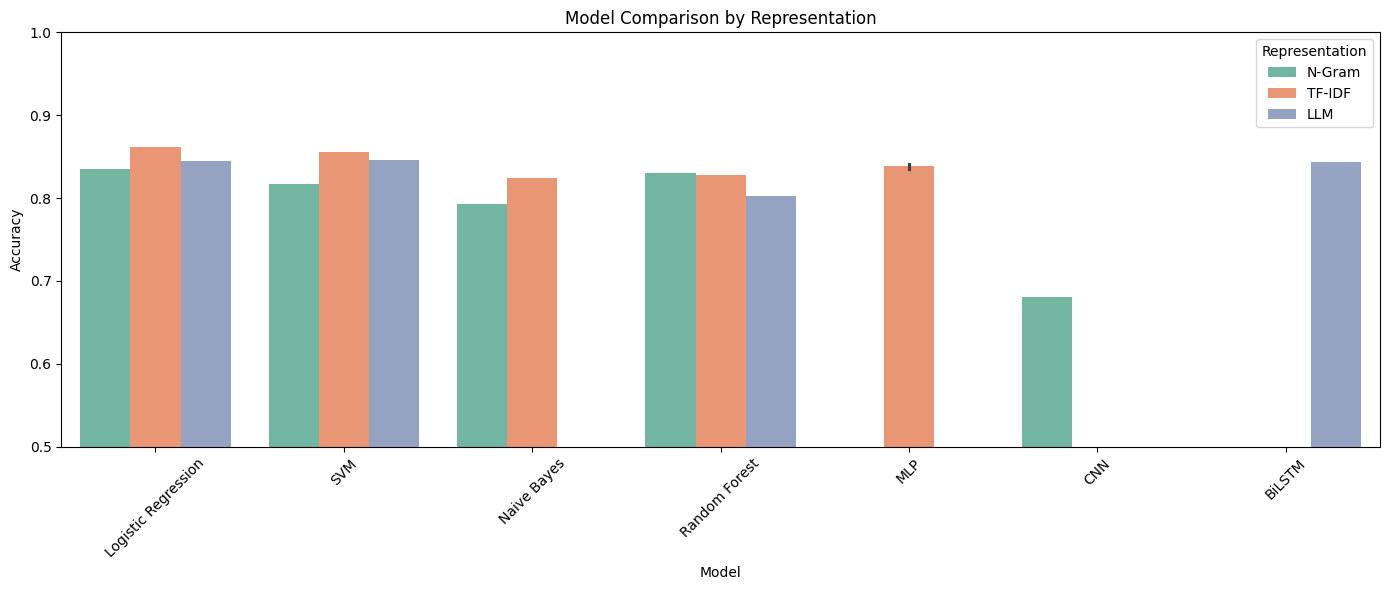

In [21]:
# Visualization
plt.figure(figsize=(14, 6))
sns.barplot(data=results_df, x='Model', y='Accuracy', hue='Representation', palette='Set2')
plt.title('Model Comparison by Representation')
plt.xticks(rotation=45)
plt.ylim(0.5, 1.0)
plt.legend(title='Representation')
plt.tight_layout()
plt.savefig('../references/fig_all_models_comparison.png', dpi=150)
plt.show()

---
## 7. Save Best Models for Inference (+2 pts)

In [18]:
# Save best ML model (SVM + TF-IDF)
with open('../models/best_ml_model.pkl', 'wb') as f:
    pickle.dump(svm_tfidf, f)
print("✅ Best ML model saved: models/best_ml_model.pkl")

# Save best DL model
torch.save(mlp_tfidf.state_dict(), '../models/best_dl_model.pth')
print("✅ Best DL model saved: models/best_dl_model.pth")

# Save model config
import json
config = {
    'ml_model': 'SVM',
    'ml_representation': 'TF-IDF',
    'dl_model': 'MLP',
    'dl_representation': 'TF-IDF',
    'tfidf_max_features': 5000,
    'input_dim': X_train_tfidf.shape[1],
    'polarity_map': {'negative': 0, 'neutral': 1, 'positive': 2},
    'inverse_polarity_map': {0: 'negative', 1: 'neutral', 2: 'positive'}
}
with open('../models/config.json', 'w') as f:
    json.dump(config, f, indent=2)
print("✅ Config saved: models/config.json")

✅ Best ML model saved: models/best_ml_model.pkl
✅ Best DL model saved: models/best_dl_model.pth
✅ Config saved: models/config.json


## 8. Confusion Matrices

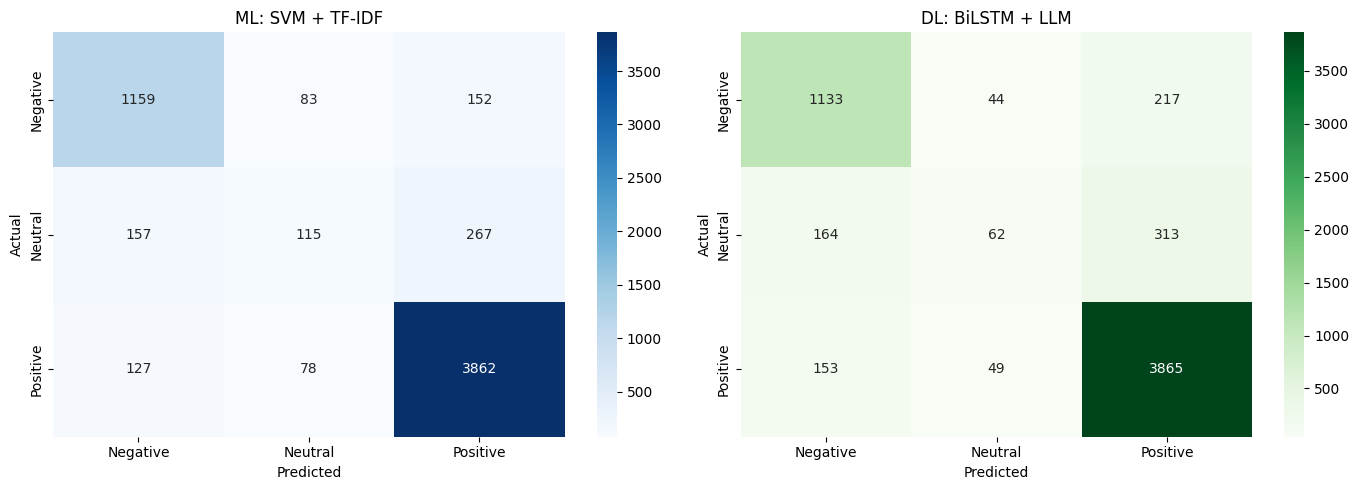

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ML Confusion Matrix
cm_ml = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm_ml, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
axes[0].set_title('ML: SVM + TF-IDF')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# DL Confusion Matrix
cm_dl = confusion_matrix(y_test, dl_preds)
sns.heatmap(cm_dl, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
axes[1].set_title('DL: BiLSTM + LLM')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.savefig('../references/fig_confusion_matrices.png', dpi=150)
plt.show()

## Barème:
- ✅ Repr. N-grammes (1 pt)
- ✅ Repr. TF-IDF (1 pt)
- ✅ Repr. LLM embeddings (1 pt)
- ✅ ML classiques: plusieurs modèles (4 pts)
- ✅ ML + N-gram (1 pt)
- ✅ ML + TF-IDF (1 pt)
- ✅ ML + LLM (1 pt)
- ✅ Deep Learning: plusieurs architectures (4 pts)
- ✅ Deep + N-gram (1 pt)
- ✅ Deep + TF-IDF (1 pt)
- ✅ Deep + LLM (1 pt)
- ✅ Modèle inférence optimal (2 pts)
- ✅ Modèle inférence test (3 pts)